In [1]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps

from mri_data import file_manager as fm

In [2]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
work_home = drive_root / "srs-9/longitudinal"
data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/data0")
date_format = "%Y%m%d"
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv("/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv",
                              index_col="subid").dropna()

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv("/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", 
                              index_col="index")

with open(dataroot / "subject-sessions-longit.json", 'r') as f:
    subject_sessions = json.load(f)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
ventricle_dists = pd.read_csv(data_dir / "centroid-ventricle_SDT.csv", index_col="subid")

df_clinical = pd.read_csv("/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid")

viridis = colormaps['viridis'].resampled(20)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/h/3Tpioneer_bids/subject-sessions-longit.json'

In [3]:
def get_subject_data(subid):
    sessions = sorted(subject_sessions[subid])
    work_dir = work_home / f"sub{subid}"

    session_volumes = defaultdict(list)
    # just copy first and last to speed things up
    sessions = sorted(sessions)
    sessions = [sessions[0], sessions[-1]]
    for sesid in sessions:
        ses_dataL = pd.read_csv(work_dir / "left" / f"hipsthomas_vols_jacobians-{sesid}.csv", index_col="struct")
        ses_dataR = pd.read_csv(work_dir / "right" / f"hipsthomas_vols_jacobians-{sesid}.csv", index_col="struct")
        vols = []
        for i in ses_dataL.index:
            left_vol = ses_dataL.loc[i, 'volumes'] / np.exp(ses_dataL.loc[i, 'jac_det'])
            right_vol = ses_dataR.loc[i, 'volumes'] / np.exp(ses_dataR.loc[i, 'jac_det'])
            vols.append(left_vol+right_vol)
        session_volumes[sesid] = vols

    df = pd.DataFrame(session_volumes, index=ses_dataL.index)
    data = pd.DataFrame({}, index=df.index)
    data['dist'] = choroid_dists.loc[int(subid), :].tolist()
    # data['dist'] = ventricle_dists.loc[int(subid), :].tolist()
    changes = [(row[sessions[-1]] - row[sessions[0]])/row[sessions[0]] for _,row in df.iterrows()]
    data['change'] = changes

    delta = datetime.strptime(str(df.columns[-1]), date_format) - datetime.strptime(str(df.columns[0]), date_format)
    t_delta = delta.days

    return {'data': data, 't_delta': t_delta}

In [24]:
all_subjects = []
for folder in work_home.glob("sub*"):
    if len(list((folder / "left").glob("*.csv"))) > 0:
           all_subjects.append(re.match(r"sub(\d{4})", folder.name)[1])

In [25]:
subjects = [subid for subid in all_subjects if df_clinical.loc[int(subid), "dz_type5"] == "PMS"]
# subjects = all_subjects
data_structs = {}
for subid in subjects:
    data_structs[subid] = get_subject_data(subid)
data_eg = data_structs[subjects[0]]['data']

In [26]:
def adjust_change(model_data, covariates):
    outcome = "change"
    formula = f"{outcome} ~ {" + ".join(covariates)}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    change = res.params['Intercept']
    for covar in covariates:
        change = change + res.params[covar] * model_data[covar].mean()
    return change

In [ ]:
covariates = ["dzdur"]
mean_changes = []
adjusted_changes = []
dists = []
for roi_ind in data_eg.index:
    model_data = df_clinical.copy()
    for subid, struct in data_structs.items():
        model_data.loc[int(subid), 'dist'] = struct['data'].loc[roi_ind, 'dist']
        model_data.loc[int(subid), 't_delta'] = struct['t_delta']
        model_data.loc[int(subid), 'change'] = struct['data'].loc[roi_ind, 'change'] / struct['t_delta']

    change = adjust_change(model_data, covariates)
    mean_changes.append(model_data['change'].mean())
    adjusted_changes.append(change)
    dists.append(model_data['dist'].mean())

adjusted_changes = pd.DataFrame({'mean_change': mean_changes, 'change': adjusted_changes, 'dist': dists}, index=data_eg.index)

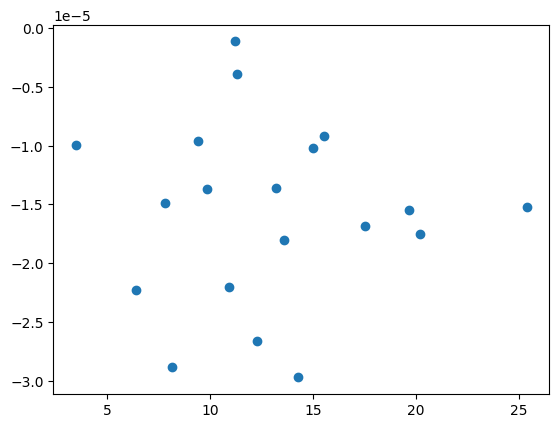

In [33]:
plt.scatter(adjusted_changes['dist'], adjusted_changes['change'])

In [24]:
covariates = ["age", "Female", "t_delta"]
outcome = "change"
formula = f"{outcome} ~ {" + ".join(covariates)}"
res = sm.OLS.from_formula(formula, data=model_data).fit()

In [28]:
change = res.params['Intercept']
for covar in covariates:
    change = change + res.params[covar] * model_data[covar].mean()
print(change)

-0.03442623130754603


In [29]:
model_data['change'].mean()

-0.016444114464844513